# Neo4j Runway: End-to-End Graph Creation Example

*Updated: August 20, 2024 for Neo4j Runway v 0.9*



## Introduction
This notebook demonstrates how to use Neo4j Runway to:
* use an LLM to generate a graph data model from a CSV,
* generate Cypher code to load the .csv data into a Neo4j Graph Database. 

Neo4j Runway is an open source library created by my colleague [Alex Gilmore](https://medium.com/@a-gilmore). You can find the [repo here](https://github.com/a-s-g93/neo4j-runway) and a blog describing the library [here](https://medium.com/neo4j/easy-data-ingestion-with-neo4j-runway-and-arrows-app-1e5f121333a7).

As you will see in the notebook, all of this is performed **without writing a single line of Cypher.** This demonstrates the promise of using LLMs to faciliate graph generation and graph loading. 

Additionally, it is important to remember that Neo4j makes it easy to iterate on your graph data model. The goal of Neo4j Runway is to help you get started with something that is close to your final data model so that you can start working with the data as a graph as quickly as possible. 

When working wtih customers we find that many of the finishing touches on a graph data model can only come once you interact with the data in a graph database. Tools like Neo4j runway get you from tabular data to working graph database quickly. 

*Note: Neo4j Runway is in early stages of development. It is an open source project and not officially supported by Neo4j.*

## Install and Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
!pip install graphviz --quiet --upgrade
!pip install neo4j_runway --upgrade --quiet
# from neo4j_runway import Discovery, GraphDataModeler, LLM, PyIngest, UserInput
# from neo4j_runway.code_generation import PyIngestConfigGenerator
# from neo4j_runway.utils import test_database_connection



In [3]:
# !pip install python-dotenv --upgrade --quiet
from dotenv import load_dotenv
import os

In [4]:
# function to print markdown
from IPython.display import display, Markdown, Image
def print_markdown(text):
    display(Markdown(text))

## Load Environment Variables
We will need an OpenAI API key along with the URL and Password for the Neo4j database. These are stored in a local `.env` file.

In [5]:
# read in from .env file
load_dotenv(dotenv_path='.env')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
NEO4J_URL = os.getenv('NEO4J_URL')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

## Load and Explore Data
For this example we will use the record of bank failures in the United States. This data is published by the Federal Deposit Insurance Corporation (FDIC) and is available at https://www.fdic.gov/bank/individual/failed/banklist.csv. 

This data was new to me as I worked on this notebook, so I did not know what it contained or what a potential graph data model might look like. This is a good test for the LLM to see if it can generate a useful graph data model.

In [6]:
# read data directly into a dataframe 
failedBank_df = pd.read_csv('https://www.fdic.gov/bank/individual/failed/banklist.csv', encoding='ISO-8859-1')
failedBank_df.shape

(569, 7)

In [7]:
failedBank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               569 non-null    object
 1   City                    569 non-null    object
 2   State                   569 non-null    object
 3   Cert                    569 non-null    int64 
 4   Acquiring Institution   569 non-null    object
 5   Closing Date            569 non-null    object
 6   Fund                    569 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.2+ KB


In [8]:
failedBank_df.head()

,Bank Name,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,Republic First Bank dba Republic Bank,Philadelphia,PA,27332,"Fulton Bank, National Association",26-Apr-24,10546
1,Citizens Bank,Sac City,IA,8758,Iowa Trust & Savings Bank,3-Nov-23,10545
2,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544
3,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
4,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540


## Preprocess Data
The data contained spaces in the column names. Additionally, all data currently needs to be strings to be loaded into the data model, so we will take care of that first. 

In [9]:
# trim whitepace from column names
failedBank_df.columns = failedBank_df.columns.str.strip()
failedBank_df.columns

Index(['Bank Name', 'City', 'State', 'Cert', 'Acquiring Institution',
       'Closing Date', 'Fund'],
      dtype='object')

In [10]:
# convert all columns to strings
failedBank_df['Cert'] = failedBank_df['Cert'].astype(str)
failedBank_df['Closing Date'] = failedBank_df['Closing Date'].astype(str)
failedBank_df['Fund'] = failedBank_df['Fund'].astype(str)

In [11]:
# write to .csv 
failedBank_df.to_csv('data/failedBank.csv', index=False)

## Describe Data
In this section we need to create a key-value pairs describing the features of our data:
* The `general_description` should contain a high-level overview of the data. 
* The `column descriptions` should contain a dictionary with the column name as the key and a description of the column as the value.

In [13]:
USER_GENERATED_INPUT = UserInput(general_description='This dataset contains a list of failed banks in the United States.',
                                 column_descriptions={
                                            'Bank Name': 'Name of the failed bank.',
                                            'City': 'City where the failed bank was headquartered.',
                                            'State': 'State where the failed bank was headquartered.',
                                            'Cert': 'FDIC certificate number of the failed bank.',
                                            'Acquiring Institution': 'Name of the institution that acquired the failed bank.',
                                            'Closing Date': 'Date that the failed bank closed.',
                                            'Fund': 'FDIC fund number of the failed bank, which acts as a unique identifier in this data set.'
                                            }
                                )

## Use the LLM to Perform Exploratory Data Analysis
Before asking the LLM to generate a data model, we will first ask it to analyze the tabular data. This will identify statistical and categorical elements of the data that are important for generating a graph data model.

In [14]:
# instantiate llm
llm = LLM(model='gpt-4o-2024-05-13')

In [15]:
# pass data and descriptions to LLM
disc = Discovery(llm=llm, user_input=USER_GENERATED_INPUT, data=failedBank_df)
disc.run()

Based on the provided summary of the dataset, here is a preliminary analysis:

### Overall Details:
1. **Data Size and Structure**:
   - The dataset contains 569 entries and 7 columns.
   - All columns are of type `object`, indicating that they are stored as strings.

2. **Missing Values**:
   - There are no missing values in the dataset, as all columns have 569 non-null entries.

3. **Unique Values**:
   - The dataset has a mix of columns with high cardinality (many unique values) and low cardinality (few unique values).

### Feature Analysis:
1. **Bank Name**:
   - There are 551 unique bank names out of 569 entries.
   - The most frequent bank name is "The First State Bank," appearing 3 times.
   - This column can help identify individual banks and their failure patterns.

2. **City**:
   - There are 436 unique cities.
   - The most frequent city is Chicago, with 20 occurrences.
   - This column can be used to analyze geographic patterns of bank failures.

3. **State**:
   - There are 44 unique states.
   - The most frequent state is Georgia (GA), with 93 occurrences.
   - This column is crucial for state-level analysis of bank failures.

4. **Cert**:
   - Each entry has a unique FDIC certificate number (569 unique values).
   - This column serves as a unique identifier for each bank and can be used to link with other datasets.

5. **Acquiring Institution**:
   - There are 303 unique acquiring institutions.
   - The most frequent value is "No Acquirer," appearing 31 times.
   - This column is important for understanding the aftermath of bank failures and the institutions involved in acquisitions.

6. **Closing Date**:
   - There are 264 unique closing dates.
   - The most frequent closing date is "30-Oct-09," with 9 occurrences.
   - This column is essential for temporal analysis of bank failures.

7. **Fund**:
   - Each entry has a unique FDIC fund number (569 unique values).
   - This column acts as another unique identifier for each bank.
   
### Important Features:
1. **State**:
   - Given the high frequency of bank failures in certain states (e.g., Georgia), this feature is critical for geographic analysis.

2. **Acquiring Institution**:
   - Understanding which institutions frequently acquire failed banks can provide insights into the consolidation of the banking industry.

3. **Closing Date**:
   - Temporal patterns in bank failures can be analyzed using this feature, especially to identify periods of high failure rates.

4. **City**:
   - Similar to the state, the city can provide more granular geographic insights.

5. **Bank Name and Cert**:
   - These features are important for identifying and linking individual banks.

### Summary:
The dataset provides a comprehensive view of failed banks in the United States, with detailed information on their locations, acquisition status, and closure dates. The most important features for analysis appear to be `State`, `Acquiring Institution`, `Closing Date`, and `City`, as they provide critical insights into the geographic and temporal patterns of bank failures, as well as the institutions involved in the aftermath. The unique identifiers (`Bank Name` and `Cert`) are also essential for detailed and accurate analysis.

## Use LLM to Create Initial Data Model
Now that we have analyzed the statistical and categorical features of the data, we can have the LLM generate an initial data model. This initial data model will point is in the right direction, but is unlikely to be perfect. That is perfectly fine because we can continue iterating it using the LLM and then once we have the data in Neo4j. The objective is to get from the tabular data to the start of a graph data model as quickly as possible.

In [16]:
# instantiate graph data modeler 
gdm = GraphDataModeler(llm=llm, discovery=disc)

# generate model 
gdm.create_initial_model()

recieved a valid response


DataModel(nodes=[Node(label='Bank', properties=[Property(name='bankName', type='str', csv_mapping='Bank Name', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='cert', type='str', csv_mapping='Cert', csv_mapping_other=None, is_unique=False, part_of_key=True), Property(name='fund', type='str', csv_mapping='Fund', csv_mapping_other=None, is_unique=False, part_of_key=True)], csv_name=''), Node(label='Location', properties=[Property(name='city', type='str', csv_mapping='City', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='state', type='str', csv_mapping='State', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Institution', properties=[Property(name='acquiringInstitution', type='str', csv_mapping='Acquiring Institution', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Closure', properties=[Property(name='closingDate', type='str', csv_mapping='Closing Date', c

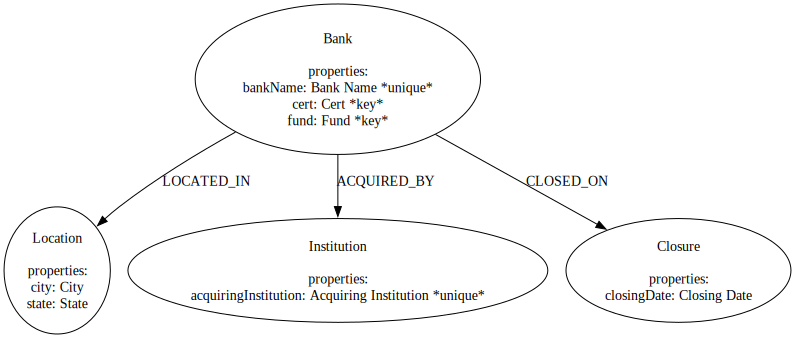

In [17]:
# visualize the data model
gdm.current_model.visualize()

## Iterate the Data Model 
Once we see the initial model we can suggest corrections. It is a best practice to make these suggestions as clear and direct as possible.

In [18]:
gdm.iterate_model(user_corrections='''
This is a good start. Please make the following updates to the graph data model:

1. Change the Location node to be a City node. Keep the property city and add a uniqueness constraint.
2. Remove the state property from the City node. Create a new node called State with the property state which must be unique. 
3. Change the name of the relationship between Bank and City from LOCATED_IN to IN_CITY.
4. Create a new relationship called IN_STATE originating with the City node and ending at the State node.
5. Remove the unique constraint from the bankName property of the Bank node. 
6. Add a uniqueness constraint to the cert property of the Bank node (it is not a key).
7. Remove the fund property from the Bank node. We will not use this data. 
8. Remove the Closure node from the data model. Add the closingDate property to the ACQUIRED_BY relationship without a uniqueness constraint.

Make only the above changes. Do not make any other changes to the graph data model. 
''')

recieved a valid response


DataModel(nodes=[Node(label='Bank', properties=[Property(name='bankName', type='str', csv_mapping='Bank Name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='cert', type='str', csv_mapping='Cert', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='City', properties=[Property(name='city', type='str', csv_mapping='City', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='State', properties=[Property(name='state', type='str', csv_mapping='State', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Institution', properties=[Property(name='acquiringInstitution', type='str', csv_mapping='Acquiring Institution', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name='')], relationships=[Relationship(type='IN_CITY', properties=[], source='Bank', target='City', csv_name=''), Relationship(type='IN_STATE', properties=[], source='City', target='Stat

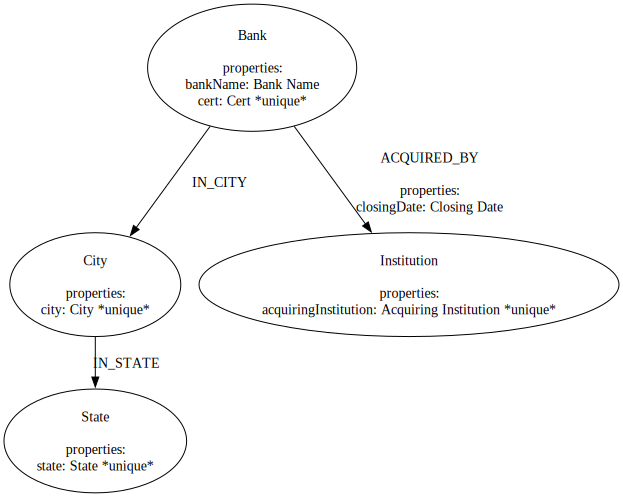

In [20]:
# visualize the updated data model
gdm.current_model.visualize()

## Generate Ingestion Code
Once we have a graph data model that we are happy with, we can generate the Cypher code and YAML file to load the data into Neo4j.

In [22]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                              username='neo4j', 
                              password=NEO4J_PASSWORD, 
                              uri=NEO4J_URL,
                              database='neo4j', 
                              file_directory="data/", 
                              csv_name="countries.csv")

In [23]:
# create ingestion YAML 
pyingest_yaml = gen.generate_config_string()

# print(pyingest_yaml)

In [70]:
# save local copy of YAML
gen.generate_pyingest_yaml_file(file_name="failedBanks")


## Load Data into Neo4j 
The last step is to load the data into Neo4j. From there we can explore the data in Neo4j itself or by using one of the Neo4j Python connectors. 

In [25]:
# verify connection to database
test_database_connection(credentials={"username": 'neo4j', "password": NEO4J_PASSWORD, "uri": NEO4J_URL})


{'valid': True, 'message': 'Connection and Auth Verified!'}

In [26]:
# ingest the data 
PyIngest(yaml_string=pyingest_yaml, dataframe=failedBank_df)


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/neo4j_runway/ingestion/pyingest.py:161: UserWarning: the yaml_string parameter will be depreciated in future releases. Please use the 'config' to identify the YAML file instead.
  warnings.warn(


File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:29.044161


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-07-25 12:49:29.432361
loading... 2 2024-07-25 12:49:29.649678
loading... 3 2024-07-25 12:49:29.788858
loading... 4 2024-07-25 12:49:29.912932
{} : Completed file 2024-07-25 12:49:30.036507
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:30.039128
loading... 1 2024-07-25 12:49:30.231605


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-07-25 12:49:30.339496
loading... 3 2024-07-25 12:49:30.446429
loading... 4 2024-07-25 12:49:30.572061
{} : Completed file 2024-07-25 12:49:30.686852
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:30.689140
loading... 1 2024-07-25 12:49:30.839992


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-07-25 12:49:30.963935
loading... 3 2024-07-25 12:49:31.072538
loading... 4 2024-07-25 12:49:31.185731
{} : Completed file 2024-07-25 12:49:31.302566
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:31.305104
loading... 1 2024-07-25 12:49:31.466181


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-07-25 12:49:31.560607
loading... 3 2024-07-25 12:49:31.645687
loading... 4 2024-07-25 12:49:31.726007
{} : Completed file 2024-07-25 12:49:31.810927
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:31.812325


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-07-25 12:49:32.058090
loading... 2 2024-07-25 12:49:32.347997
loading... 3 2024-07-25 12:49:32.465522
loading... 4 2024-07-25 12:49:32.586779
{} : Completed file 2024-07-25 12:49:32.724954
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:32.727277


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-07-25 12:49:32.938429
loading... 2 2024-07-25 12:49:33.037509
loading... 3 2024-07-25 12:49:33.125418
loading... 4 2024-07-25 12:49:33.209977
{} : Completed file 2024-07-25 12:49:33.296892
File {} .//data/countries.csv
loading... 0 2024-07-25 12:49:33.298569
loading... 1 2024-07-25 12:49:33.491771


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-07-25 12:49:33.603191
loading... 3 2024-07-25 12:49:33.696844
loading... 4 2024-07-25 12:49:33.788159
{} : Completed file 2024-07-25 12:49:33.872062


## View Graph
Now that we have the data loaded into Neo4j, we can view it using the Neo4j Browser or Neo4j Bloom.

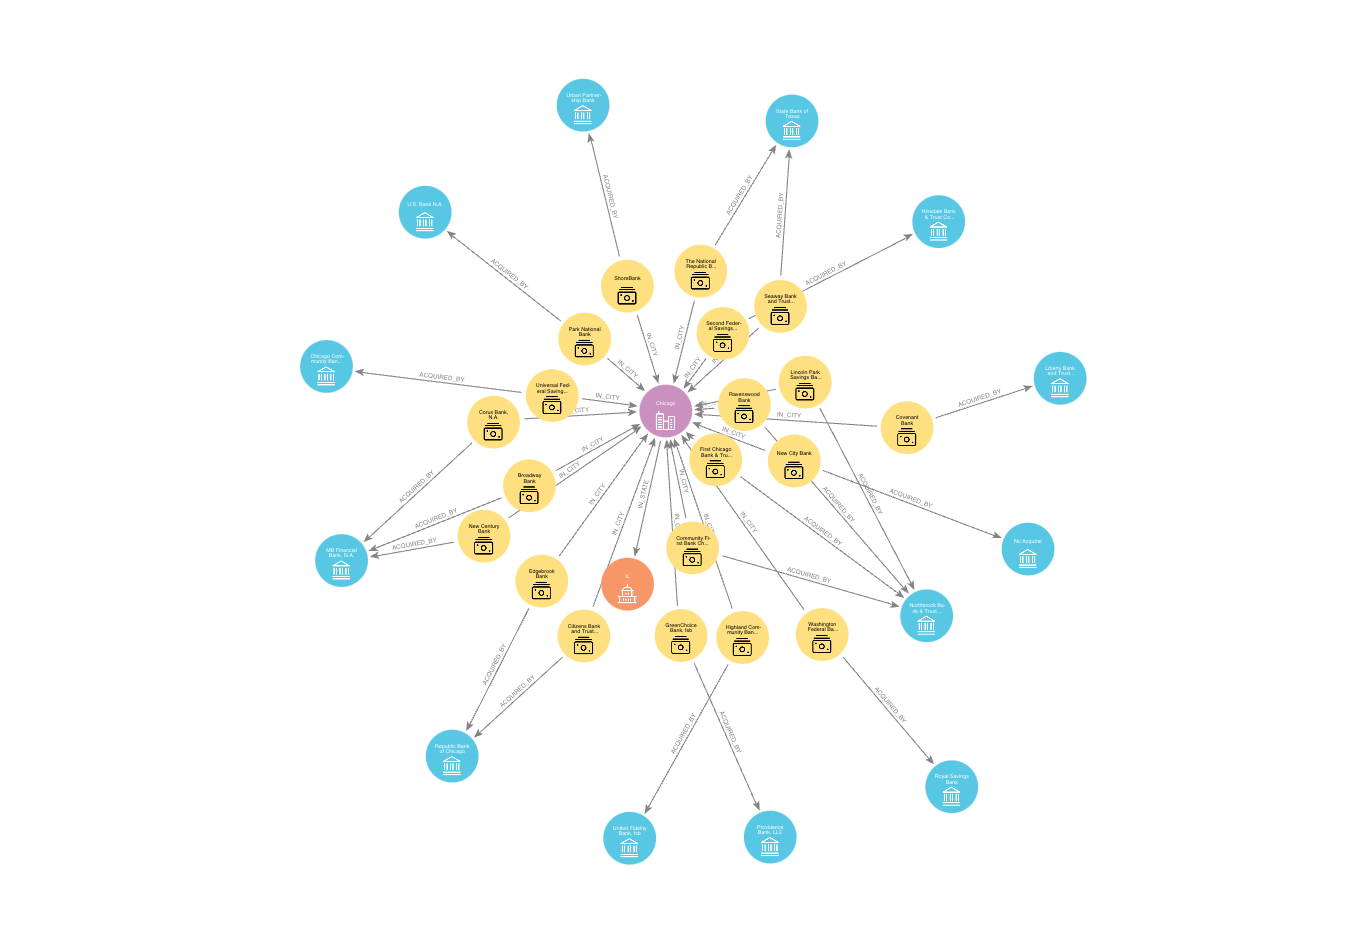

In [28]:
# display image of graph
Image(filename='banks-visualization.png')

## Conclusion
In this notebook we demonstrated how to use Neo4j Runway to explore a new tabular dataset, generate a graph data model, and load the data into Neo4j. This process is designed to be iterative and to get you from tabular data to a working graph database as quickly as possible.

Neo4j Runway is an open source project under active development and we welcome contributions and feedback.